<a href="https://colab.research.google.com/github/ajoshiusc/deep_grp_reg/blob/main/mnist_register.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import torch
import monai
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from monai.networks.nets import unet
from monai.networks.blocks import Warp
from monai.config import USE_COMPILED
from tqdm import tqdm
from torch.nn import MSELoss
import numpy as np


In [21]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import Union

import torch
from torch.nn.modules.loss import _Loss

from monai.utils import LossReduction


def spatial_gradient(x: torch.Tensor, dim: int) -> torch.Tensor:
    """
    Calculate gradients on single dimension of a tensor using central finite difference.
    It moves the tensor along the dimension to calculate the approximate gradient
    dx[i] = (x[i+1] - x[i-1]) / 2.
    Adapted from:
        DeepReg (https://github.com/DeepRegNet/DeepReg)

    Args:
        x: the shape should be BCH(WD).
        dim: dimension to calculate gradient along.
    Returns:
        gradient_dx: the shape should be BCH(WD)
    """
    slice_1 = slice(1, -1)
    slice_2_s = slice(2, None)
    slice_2_e = slice(None, -2)
    slice_all = slice(None)
    slicing_s, slicing_e = [slice_all, slice_all], [slice_all, slice_all]
    while len(slicing_s) < x.ndim:
        slicing_s = slicing_s + [slice_1]
        slicing_e = slicing_e + [slice_1]
    slicing_s[dim] = slice_2_s
    slicing_e[dim] = slice_1 #slice_2_e
    return (x[slicing_s] - x[slicing_e])# / 2.0


class BendingEnergyLoss(_Loss):
    """
    Calculate the bending energy based on second-order differentiation of pred using central finite difference.

    Adapted from:
        DeepReg (https://github.com/DeepRegNet/DeepReg)
    """

    def __init__(self, normalize: bool = False, reduction: Union[LossReduction, str] = LossReduction.MEAN) -> None:
        """
        Args:
            normalize:
                Whether to divide out spatial sizes in order to make the computation roughly
                invariant to image scale (i.e. vector field sampling resolution). Defaults to False.
            reduction: {``"none"``, ``"mean"``, ``"sum"``}
                Specifies the reduction to apply to the output. Defaults to ``"mean"``.

                - ``"none"``: no reduction will be applied.
                - ``"mean"``: the sum of the output will be divided by the number of elements in the output.
                - ``"sum"``: the output will be summed.
        """
        super().__init__(reduction=LossReduction(reduction).value)
        self.normalize = normalize

    def forward(self, pred: torch.Tensor) -> torch.Tensor:
        """
        Args:
            pred: the shape should be BCH(WD)

        Raises:
            ValueError: When ``self.reduction`` is not one of ["mean", "sum", "none"].

        """
        if pred.ndim not in [3, 4, 5]:
            raise ValueError(f"Expecting 3-d, 4-d or 5-d pred, instead got pred of shape {pred.shape}")
        for i in range(pred.ndim - 2):
            if pred.shape[-i - 1] <= 4:
                raise ValueError(f"All spatial dimensions must be > 4, got spatial dimensions {pred.shape[2:]}")
        if pred.shape[1] != pred.ndim - 2:
            raise ValueError(
                f"Number of vector components, {pred.shape[1]}, does not match number of spatial dimensions, {pred.ndim-2}"
            )

        # first order gradient
        first_order_gradient = [spatial_gradient(pred, dim) for dim in range(2, pred.ndim)]

        # spatial dimensions in a shape suited for broadcasting below
        if self.normalize:
            spatial_dims = torch.tensor(pred.shape, device=pred.device)[2:].reshape((1, -1) + (pred.ndim - 2) * (1,))

        energy = torch.tensor(0)
        for dim_1, g in enumerate(first_order_gradient):
            dim_1 += 2
            if self.normalize:
                g *= pred.shape[dim_1] / spatial_dims
                energy = energy + (spatial_gradient(g, dim_1) * pred.shape[dim_1]) ** 2
            else:
                energy = energy + spatial_gradient(g, dim_1) ** 2
            for dim_2 in range(dim_1 + 1, pred.ndim):
                if self.normalize:
                    energy = energy + 2 * (spatial_gradient(g, dim_2) * pred.shape[dim_2]) ** 2
                else:
                    energy = energy + 2 * spatial_gradient(g, dim_2) ** 2

        if self.reduction == LossReduction.MEAN.value:
            energy = torch.mean(energy)  # the batch and channel average
        elif self.reduction == LossReduction.SUM.value:
            energy = torch.sum(energy)  # sum over the batch and channel dims
        elif self.reduction != LossReduction.NONE.value:
            raise ValueError(f'Unsupported reduction: {self.reduction}, available options are ["mean", "sum", "none"].')

        return energy


In [22]:
from tensorflow.keras.datasets import mnist


(x_train_load, y_train_load), (x_test_load, y_test_load) = mnist.load_data()

digit_sel = 5

# extract only instances of the digit 5
x_train = x_train_load[y_train_load==digit_sel, ...]
y_train = y_train_load[y_train_load==digit_sel]
x_test = x_test_load[y_test_load==digit_sel, ...]
y_test = y_test_load[y_test_load==digit_sel]

# let's get some shapes to understand what we loaded.
print('shape of x_train: {}, y_train: {}'.format(x_train.shape, y_train.shape))

fixed = np.float32(x_train[3])
moving = np.float32(x_train[4])

fixed = resize(fixed,(64,64))
moving = resize(moving,(64,64))


shape of x_train: (5421, 28, 28), y_train: (5421,)


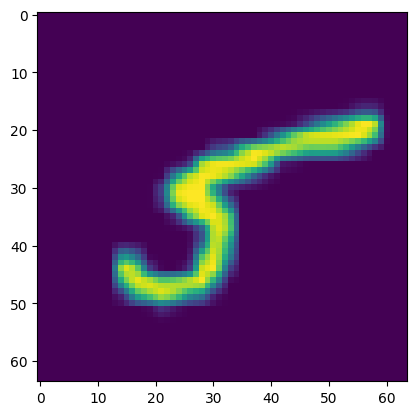

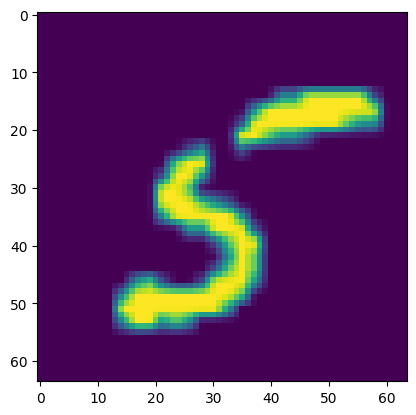

In [23]:
plt.imshow(moving)
plt.show()
plt.imshow(fixed)


Create registration network

In [24]:
reg = unet.UNet(spatial_dims=2,  # spatial dims
    in_channels=2,
    out_channels=2,# output channels (to represent 2D displacement vector field)
    channels=(16, 32, 32, 32, 32),  # channel sequence
    strides=(1, 2, 2, 4),  # convolutional strides
    dropout=0.2,
    norm="batch").to('cuda')

if USE_COMPILED:
    warp_layer = Warp(2, padding_mode="zeros").to('cuda')
else:
    warp_layer = Warp("bilinear", padding_mode="zeros").to('cuda')


reg.train()
optimizerR = torch.optim.Adam(reg.parameters(), lr=0.001)


In [25]:
image_loss = MSELoss() 
regularization_loss = BendingEnergyLoss()
image_loss.to('cuda')

MSELoss()

In [26]:
input_data = torch.cat((torch.tensor(moving[None,]), torch.tensor(fixed[None,])), dim=0)
input_data = input_data[None, ].to('cuda')

max_epochs = 1000

moving = torch.tensor(moving[None,None,]).to('cuda')
fixed = torch.tensor(fixed[None,None,]).to('cuda')

for epoch in tqdm(range(max_epochs)):

    optimizerR.zero_grad()
    ddf = reg(input_data)
    moved = warp_layer(moving, ddf)

    imgloss = image_loss(moved, fixed) + 10*regularization_loss(ddf)

    imgloss.backward()
    optimizerR.step()





100%|██████████| 1000/1000 [00:15<00:00, 63.00it/s]


In [27]:


print(10000*regularization_loss(ddf))
print(image_loss(moved, fixed))

tensor(23511.9453, device='cuda:0', grad_fn=<MulBackward0>)
tensor(114.4488, device='cuda:0', grad_fn=<MseLossBackward0>)


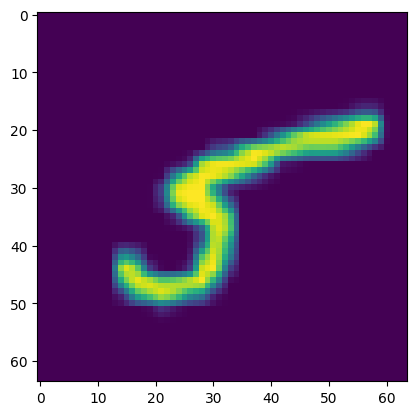

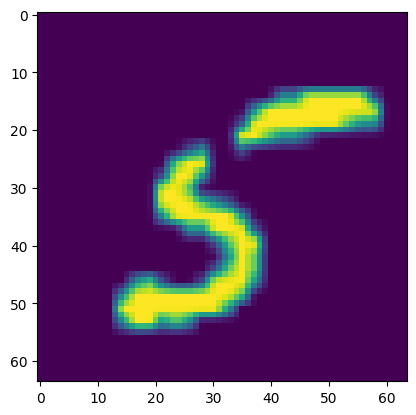

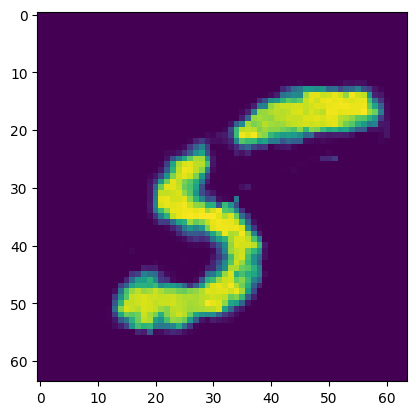

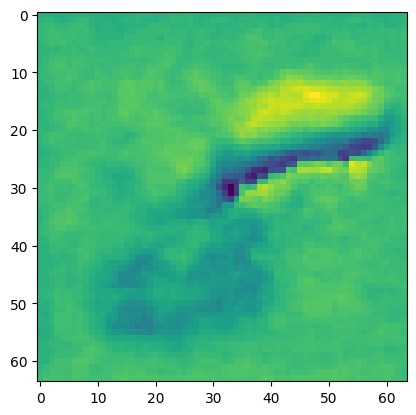

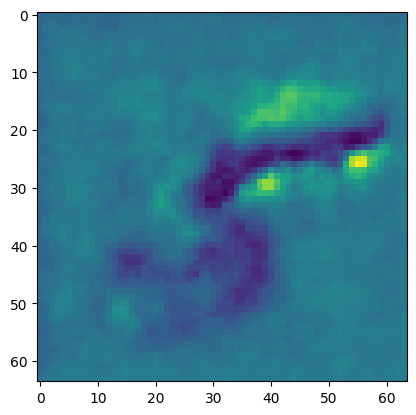

In [28]:
plt.imshow(moving[0,0].to('cpu').numpy())
plt.show()
plt.imshow(fixed[0,0].to('cpu').numpy())
plt.show()
plt.imshow(moved[0,0].detach().to('cpu').numpy())
plt.show()
plt.imshow(ddf[0,0].detach().to('cpu').numpy())
plt.show()
plt.imshow(ddf[0,1].detach().to('cpu').numpy())
